In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import jax
import jax.numpy as jnp
import visualization
from utils import results, experiments, settings
import os
import global_settings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
result = results.ResultSample.load_from_file(
    "/home/gw/data/experiments/master_thesis/results/1cd0fb4d70b0c0c9bc850afe49a45128.tar.gz"
)
experiment = experiments.FactoryExperiment(result.experiment_type, **{"settings": result.settings})()

normalized probabilities: [0.5665243  0.3504857  0.08298998]


samples_parameters_fs.shape (1274, 10)


100%|███████████████████████████████████████| 1024/1024 [00:02<00:00, 346.28it/s]


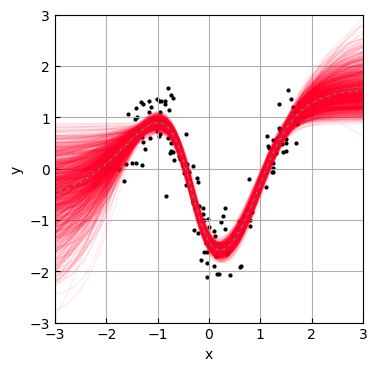

In [11]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(0))
samples_parameters_fs = jax.random.permutation(rng_key_, result.samples["parameters"])
print("samples_parameters_fs.shape", samples_parameters_fs.shape)

n = 2**10
if len(experiment._dataset.conditional_indices) > 1:
    n = 2**4

figure = visualization.RegressionFigure(
    settings=settings.SettingsRegressionFigure(
        settings_plot=settings.SettingsPlot(
            alpha=0.08,
            epistemic=False
        )
    )
)
figure.plot(
    dataset=experiment._dataset,
    transformation=experiment._model_transformation.apply_from_vector,
    parameters_list=[samples_parameters_fs[:n]],
    std=result.samples["std"].mean()
)

In [12]:
figure._figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_fs_full.png"), bbox_inches="tight", dpi=96)

100%|████████████████████████████████████████████| 10/10 [00:01<00:00,  6.29it/s]


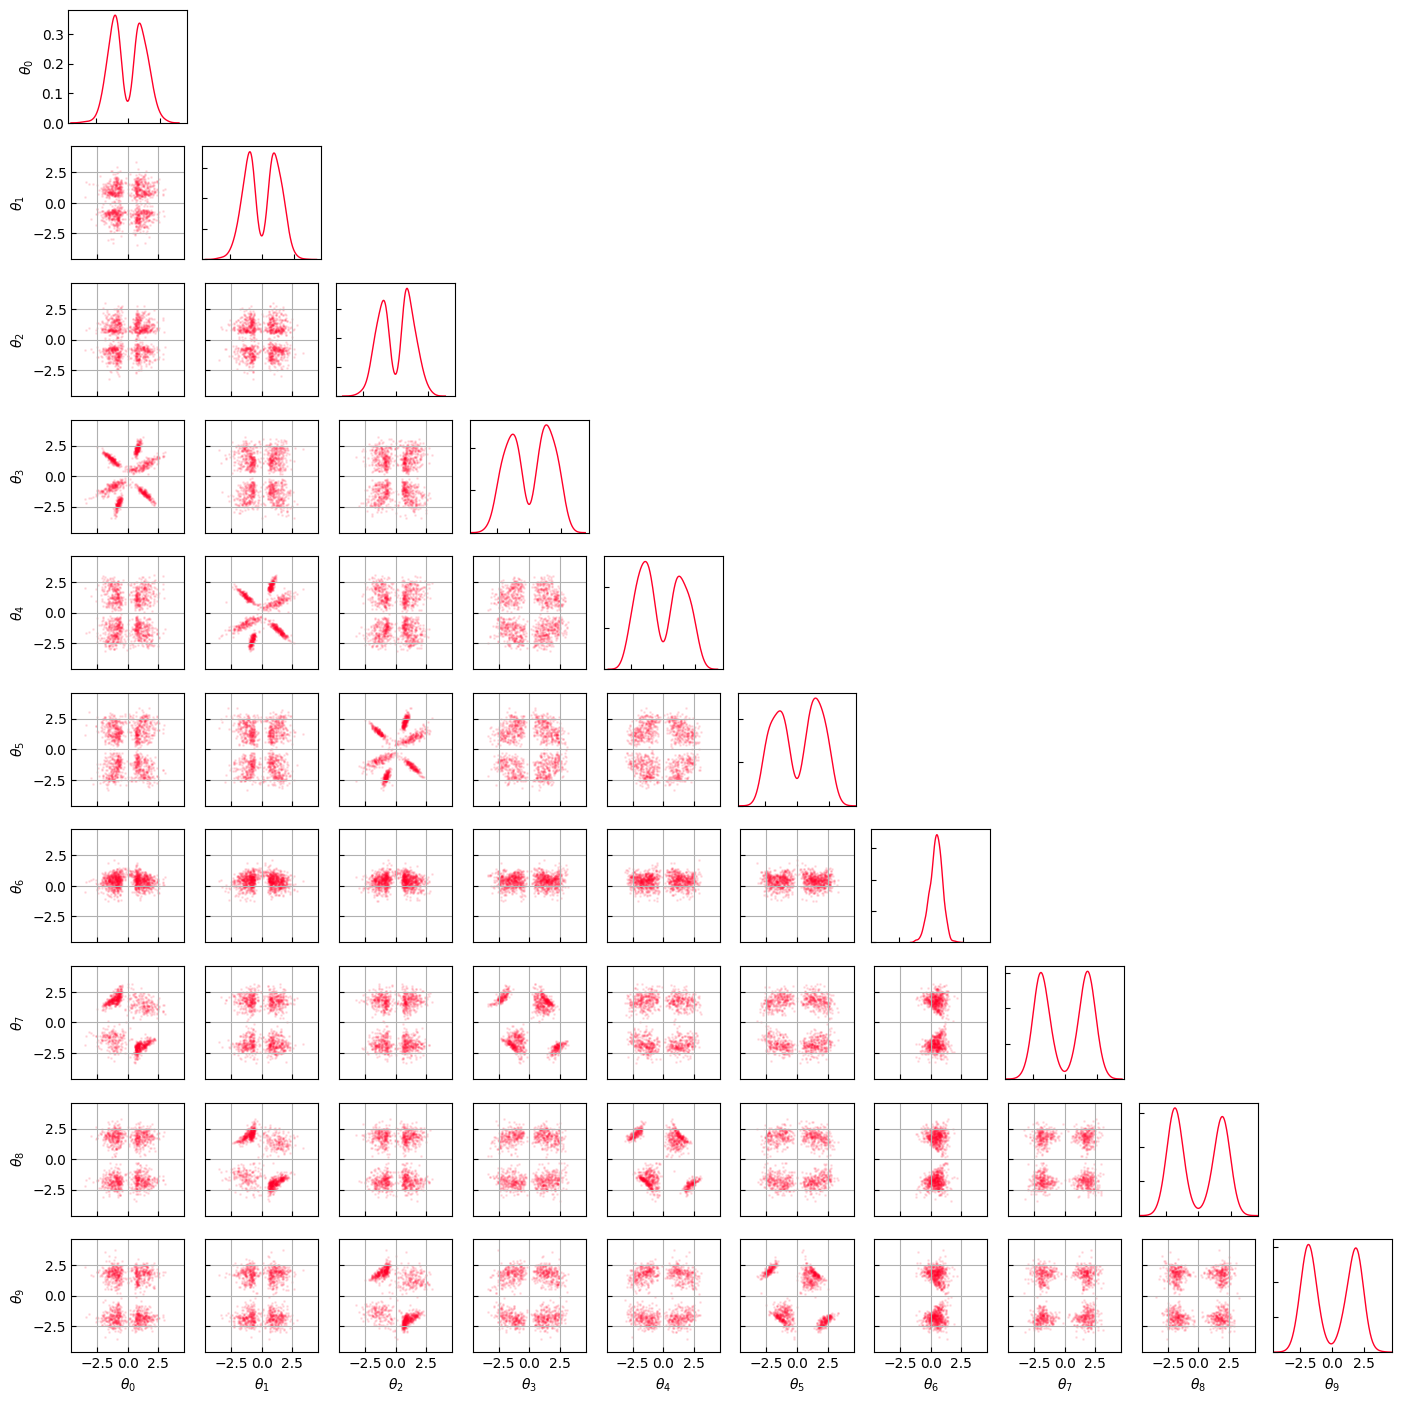

In [5]:
rng_key, rng_key_ = jax.random.split(rng_key)
samples_parameters_posterior = samples_parameters_fs
#if samples_parameters_posterior.shape[-1] > 10:
#    samples_parameters_posterior = samples_parameters_posterior[:, jax.random.permutation(rng_key_, jnp.arange(samples_parameters_fs.shape[-1]))[:10]]

figure = visualization.TriangleFigure(
    settings=settings.SettingsTriangleFigure(
        prefix=r"\theta",
        settings_scatter=settings.SettingsScatter(
            alpha=0.1,
            size=1.0
        )
    )
)
figure.plot(
    data_list=[samples_parameters_posterior]
)

In [10]:
figure._figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_posterior_full.png"), bbox_inches="tight", dpi=96)